# LSTM 4
### * lag, ma, 변동률(pct) 중심 시계열 특화 피처만
### * Bidirectional LSTM


In [ ]:
!pip install tensorflow scikit-learn pandas numpy matplotlib

In [ ]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/all_features.csv', index_col=0, parse_dates=True)

In [ ]:
# 쉼표 제거 및 숫자형 변환
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 결측치 제거
df = df.dropna()

In [ ]:
target_col = '원/미국달러(매매기준율)'

# 타깃 기준 파생
df['환율_lag1'] = df[target_col].shift(1)
df['환율_ma3'] = df[target_col].rolling(3).mean()
df['환율_pct'] = df[target_col].pct_change()
df['환율_diff'] = df[target_col].diff()

# 자산 가격 관련
for col in ['금', '은', '원유', 'KOSPI', 'NASDAQ']:
    df[f'{col}_pct'] = df[col].pct_change()
    df[f'{col}_diff'] = df[col].diff()

# 금리 관련
for col in ['국고채(3년)(%)', '국고채(10년)(%)', '기준금리', 'CD(91일)', '무담보콜금리(1일, 전체거래)']:
    df[f'{col}_diff'] = df[col].diff()

# 무역 지표
for col in ['수출물가지수(달러기준)', '수입물가지수(달러기준)']:
    df[f'{col}_pct'] = df[col].pct_change()

# 심리지표
for col in ['뉴스심리지수', '경제심리지수', '미국 소비자심리지수']:
    df[f'{col}_diff'] = df[col].diff()

df = df.dropna()

In [ ]:
# 'lag', 'ma', 'pct', 'diff' 포함된 컬럼만 선택
selected_cols = [col for col in df.columns if any(kw in col.lower() for kw in ['lag', 'ma', 'pct', 'diff'])]
X = df[selected_cols]
y = df[target_col]

In [ ]:
# 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# 시퀀스 (30일 → 60일)
def create_sequences(X, y, seq_len=60):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len=60)

In [ ]:
# train/test
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


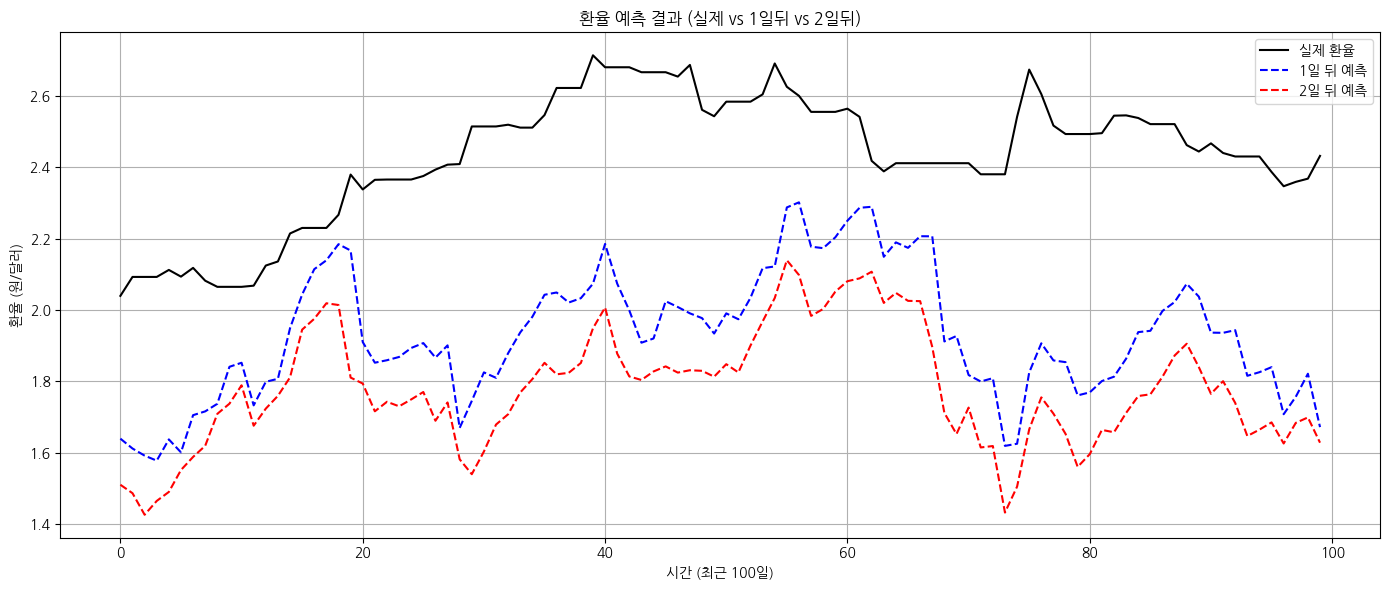

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import koreanize_matplotlib

# ✅ 예측 함수: n일 뒤 예측
def predict_n_steps(model, X_input, n_days):
    preds = []
    input_seq = X_input.copy()

    for _ in range(n_days):
        pred = model.predict(input_seq.reshape(1, input_seq.shape[0], input_seq.shape[1]), verbose=0)[0][0]
        preds.append(pred)
        # 다음 입력을 위해 시퀀스 업데이트
        input_seq = np.roll(input_seq, -1, axis=0)
        input_seq[-1] = pred
    return preds

# ✅ 실제값 및 입력 데이터
n = 100  # 마지막 시점부터 n개 구간을 시각화
X_input = X_test[-1]   # 테스트 데이터 마지막 샘플
y_true = y_test[-n:]

# ✅ 예측 (1일, 2일 뒤)
pred_1d = model.predict(X_test)[-n:].flatten()
pred_2d = []

for i in range(-n, 0):
    p2 = predict_n_steps(model, X_test[i], 2)[-1]  # 이틀 뒤 예측
    pred_2d.append(p2)

# ✅ 시각화
plt.figure(figsize=(14, 6))
plt.plot(range(n), y_true, label='실제 환율', color='black')
plt.plot(range(n), pred_1d, label='1일 뒤 예측', linestyle='--', color='blue')
plt.plot(range(n), pred_2d, label='2일 뒤 예측', linestyle='--', color='red')
plt.title('환율 예측 결과 (실제 vs 1일뒤 vs 2일뒤)')
plt.xlabel('시간 (최근 {}일)'.format(n))
plt.ylabel('환율 (원/달러)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Bidirectional LSTM 모델
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[es]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - loss: 0.2058 - val_loss: 0.0170
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - loss: 0.0269 - val_loss: 0.0072
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0176 - val_loss: 0.0084
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - loss: 0.0205 - val_loss: 0.0091
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 0.0303 - val_loss: 0.0146
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 36s 107ms/step - loss: 0.0456 - val_loss: 0.0085
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 0.0200 - val_loss: 0.0100


In [ ]:
# 정규화 복원 (역변환)
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [ ]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print("LSTM 4 예측 성능")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

LSTM 4 예측 성능
MSE: 1278.91
MAE: 27.19
RMSE: 35.76
R²: 0.8487


In [ ]:
# ✅ 필요한 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 데이터 불러오기
# df = pd.read_csv('/content/all_features.csv')  # 파일 경로 확인
df['DATE'] = pd.to_datetime(df['DATE'])

# ✅ 파라미터 설정
target_col = '원/미국달러(매매기준율)'
window_size = 60
forecast_days = 3  # 1~3일 후까지 예측

# ✅ 피처/타겟 분리
features = df.drop(columns=['DATE', target_col])
target = df[target_col]

# ✅ 정규화
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# ✅ 슬라이딩 윈도우 함수
def make_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y_scaled, window_size)

# ✅ 학습/테스트 분할 (80% 고정, shuffle X)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# ✅ 모델 정의
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# ✅ 모델 학습
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, shuffle=False, callbacks=[es], verbose=0)

# ✅ 예측 및 복원
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# ✅ 성능 평가
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# ✅ 향후 n일 예측
last_window = X_scaled[-window_size:]
future_preds = []

current_input = last_window.copy()
for i in range(forecast_days):
    input_seq = current_input.reshape(1, window_size, -1)
    pred_scaled = model.predict(input_seq)
    pred_inv = scaler_y.inverse_transform(pred_scaled)[0][0]
    future_preds.append(pred_inv)

    # 예측값 이어붙여 다음 step 입력 준비
    next_input = np.append(current_input[1:], [current_input[-1]], axis=0)
    current_input = next_input

# ✅ 결과 출력
for i, val in enumerate(future_preds):
    print(f"{i+1}일 뒤 예측 환율: {val:.2f} 원")

# ✅ 시각화
dates = pd.date_range(df['DATE'].iloc[-1], periods=forecast_days + 1, freq='D')[1:]
plt.figure(figsize=(10, 5))
plt.plot(dates, future_preds, marker='o', label='예측 환율')
plt.title('향후 환율 예측 (1~3일 후)')
plt.ylabel('환율 (원/달러)')
plt.grid(True)
plt.legend()
plt.show()

KeyError: 'DATE'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 데이터 불러오기
# df = pd.read_csv('/content/all_features.csv')
# df['DATE'] = pd.to_datetime(df['DATE'])

# ✅ 설정
target_col = '원/미국달러(매매기준율)'
window_size = 60
forecast_days = 31

# ✅ 피처/타겟 분리
features = df.drop(columns=['DATE', target_col])
target = df[target_col]

# ✅ 정규화
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# ✅ 슬라이딩 윈도우 데이터 생성
def make_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y_scaled, window_size)

# ✅ 학습/테스트 분할
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# ✅ 모델 정의 및 학습
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, shuffle=False, callbacks=[es], verbose=0)

# ✅ 3월 예측 시작 (마지막 윈도우부터)
last_window = X_scaled[-window_size:]
future_preds = []

current_input = last_window.copy()
for _ in range(forecast_days):
    input_seq = current_input.reshape(1, window_size, -1)
    pred_scaled = model.predict(input_seq, verbose=0)
    pred_inv = scaler_y.inverse_transform(pred_scaled)[0][0]
    future_preds.append(pred_inv)

    # 다음 입력 준비: 가장 마지막에 예측값 추가
    next_row = current_input[-1].copy()
    current_input = np.vstack([current_input[1:], next_row])  # 슬라이딩 유지

# ✅ 결과 시각화
start_date = df['DATE'].max() + pd.Timedelta(days=1)
future_dates = pd.date_range(start=start_date, periods=forecast_days, freq='D')

plt.figure(figsize=(12, 5))
plt.plot(future_dates, future_preds, marker='o', label='예측 환율')
plt.title('2025년 3월 환율 예측 (Bidirectional LSTM)')
plt.xlabel('날짜')
plt.ylabel('환율 (원/달러)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ 테이블 형태로 보기
pred_df = pd.DataFrame({'날짜': future_dates, '예측 환율': future_preds})
from IPython.display import display
display(pred_df)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# 1. 모델 빌드 함수 정의
def build_lstm_model(seq_len, n_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(seq_len, n_features)))
    model.add(Dropout(0.2))  # 너가 튜닝한 Dropout 반영
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# 2. 교차검증 파라미터 세팅
mse_scores = []
mae_scores = []
r2_scores = []

initial_window = int(len(X_seq) * 0.6)  # 초기 학습 데이터 크기 (60%)
step_size = int(len(X_seq) * 0.1)        # 검증 데이터 크기 (10%)

# 3. Time Series 교차검증 루프
for i, start in enumerate(range(initial_window, len(X_seq) - step_size, step_size)):
    print(f"\n📦 Fold {i+1}")

    # 학습/검증 데이터 분리
    X_train_cv, y_train_cv = X_seq[:start], y_seq[:start]
    X_val_cv, y_val_cv = X_seq[start:start + step_size], y_seq[start:start + step_size]

    # 모델 생성
    model = build_lstm_model(seq_len=X_train_cv.shape[1], n_features=X_train_cv.shape[2])

    # EarlyStopping 설정
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 학습
    model.fit(
        X_train_cv, y_train_cv,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        shuffle=False,
        callbacks=[es],
        verbose=0
    )

    # 검증 데이터 예측
    y_pred_cv = model.predict(X_val_cv, verbose=0)

    # 성능 측정
    mse = mean_squared_error(y_val_cv, y_pred_cv)
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    r2 = r2_score(y_val_cv, y_pred_cv)

    print(f"  ✅ MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# 4. 전체 평균 결과 출력
print("\n📊 전체 평균 성능")
print(f"▶ 평균 MSE : {np.mean(mse_scores):.4f}")
print(f"▶ 평균 MAE : {np.mean(mae_scores):.4f}")
print(f"▶ 평균 R²  : {np.mean(r2_scores):.4f}")

### 실제 예측률

In [ ]:
# ✅ 마지막 60일 기준으로 3월 예측 시작 (LSTM 출력 = 환율 그 자체)
last_60_X = X_scaled[-60:].copy()  # (60, 변수 수)
predicted_rates = []

for _ in range(31):  # 3월 예측: 31일
    # 입력은 항상 최신 60일
    pred = model.predict(last_60_X.reshape(1, 60, -1), verbose=0)

    # 스케일 복원 (환율 자체 예측)
    pred_rate = scaler_y.inverse_transform(pred)[0][0]
    predicted_rates.append(pred_rate)

    # 다음 입력 구성: 마지막 행 복사해서 사용 (예측값으로는 X 못 업데이트하므로 관측된 최신 피처 그대로 유지)
    next_input = last_60_X[-1].copy()  # 구조 유지용
    last_60_X = np.vstack([last_60_X[1:], next_input])  # 단순한 sliding window

# ✅ 변화율 계산 (전일 대비 비율 변화 %)
predicted_returns = [0]  # 첫 날은 변화율 없음
for i in range(1, len(predicted_rates)):
    change = (predicted_rates[i] - predicted_rates[i-1]) / predicted_rates[i-1] * 100
    predicted_returns.append(change)

# ✅ 결과 출력
future_dates = pd.date_range(start="2025-03-01", periods=31)
pred_df = pd.DataFrame({
    "DATE": future_dates,
    "예측_환율": predicted_rates,
    "예측_변화율(%)": predicted_returns
})

print("📊 LSTM 기반 3월 환율 예측 결과 (환율 자체 예측 기준):")
print(pred_df.to_string(index=False))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(pred_df["DATE"], pred_df["예측_환율"], label='예측 환율', marker='o')
plt.title("LSTM 예측 기반 2025년 3월 환율 전망")
plt.xlabel("날짜")
plt.ylabel("원/달러 환율")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd

# 3월 1일부터 3월 31일까지의 환율 데이터 다운로드
df_real = yf.download('USDKRW=X', start='2025-03-01', end='2025-04-01')

# 'Close' 열을 '실제 환율'로 이름 변경
df_real = df_real[['Close']].rename(columns={'Close': '실제 환율'})

# 인덱스를 'DATE' 열로 변환
df_real.reset_index(inplace=True)
df_real['DATE'] = df_real['Date'].dt.date
df_real.drop(columns=['Date'], inplace=True)

In [ ]:
print(df_real.head())

In [ ]:
pred_df = pred_df.sort_values(by='DATE').reset_index(drop=True)
df_real = df_real.sort_values(by='DATE').reset_index(drop=True)

In [ ]:
# 예측 데이터프레임에 실제 환율 열 붙이기 (순서 기준)
pred_df['실제 환율'] = df_real['실제 환율']

# 오차 계산
pred_df['예측 오차(원)'] = pred_df['예측_환율'] - pred_df['실제 환율']
pred_df['예측 오차율(%)'] = pred_df['예측 오차(원)'] / pred_df['실제 환율'] * 100

In [ ]:
print("📊 예측 vs 실제 비교 결과 (병합 없이 정렬 기반):")
print(pred_df[['DATE', '예측_환율', '실제 환율', '예측 오차(원)', '예측 오차율(%)']].to_string(index=False))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(pred_df['DATE'], pred_df['실제 환율'], label='실제 환율', marker='o')
plt.plot(pred_df['DATE'], pred_df['예측_환율'], label='예측 환율', marker='x')
plt.title("2025년 3월 환율 예측 vs 실제 (정렬 기반)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### train/test loss

In [ ]:
import matplotlib.pyplot as plt

# 학습 기록 시각화
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='test loss')
    plt.title('train/test loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(history)

In [ ]:
def evaluate_history(history):
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    result = {
        '최종 훈련 손실': train_losses[-1],
        '최종 검증 손실': val_losses[-1],
        '최소 훈련 손실': min(train_losses),
        '최소 검증 손실': min(val_losses),
        '최소 손실 차이': abs(min(train_losses) - min(val_losses)),
        '최소 검증 손실 발생 에포크': val_losses.index(min(val_losses)) + 1
    }

    return pd.DataFrame(result, index=['값'])

In [ ]:
evaluate_history(history)

In [ ]:
import pandas as pd
import numpy as np

# 마지막 60일 데이터 (seq_len=60)
last_60_X = X_scaled[-60:].copy()

# 마지막 실제 환율
last_rate = df[target_col].iloc[-1]

# 예측일 계산
start_date = pd.to_datetime(df.index[-1]) + pd.Timedelta(days=1)
target_date = pd.to_datetime("2025-05-13")
days_to_predict = (target_date - start_date).days + 1  # 오늘 다음날부터 5/13일까지 예측해야 하는 일수

predicted_returns = []  # 변화율 저장
predicted_rates = [last_rate]  # 실제 환율 저장 (초기값은 마지막 실제 환율)

# 예측 루프
for _ in range(days_to_predict):
    # 마지막 60일 데이터 기준 예측
    pred = model.predict(last_60_X.reshape(1, 60, -1), verbose=0)
    pred_return = scaler_y.inverse_transform(pred)[0][0] / 100  # 변화율 복원
    predicted_returns.append(pred_return * 100)  # %로 저장
    next_rate = predicted_rates[-1] * (1 + pred_return)
    predicted_rates.append(next_rate)

    # 마지막 60일 시퀀스 업데이트 (새 예측을 추가)
    last_60_X = np.vstack([last_60_X[1:], last_60_X[-1]])

# 최종 결과
predicted_rates = predicted_rates[1:]  # 초기값 제외

# 날짜 생성
future_dates = pd.date_range(start=start_date, periods=days_to_predict)

# 결과 데이터프레임
pred_df = pd.DataFrame({
    "DATE": future_dates,
    "예측_환율": predicted_rates,
    "예측_변화율(%)": predicted_returns
})

# 5월 13일 결과 출력
result_513 = pred_df[pred_df['DATE'] == target_date]
print("📈 2025년 5월 13일 환율 예측 결과:")
print(result_513)

In [ ]:
# ✅ 필요한 라이브러리
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 데이터 불러오기
# df = pd.read_csv('/content/your_file.csv')

# ✅ 설정
window_size = 60
lstm_epochs = 100
lstm_batch_size = 32
n_splits = 5  # Rolling Forecast용 split 수 설정

# ✅ 타겟 설정
target_column = '원/미국달러(매매기준율)'
selected_features_list = [
    'KOSPI', '기준금리', '수출물가지수(원화기준)', '수입물가지수(원화기준)',
    'PPI', '한국실업률', '금', '은', '원유', '중국위안/달러',
    'NASDAQ', '외환보유액(천달러)', '미국PPI', '뉴스심리지수',
    '대외채무', '본원 통화(달러 발행량)', 'CPI', '장단기금리차', 'GDP_GROWTH(%)'
]

# ✅ 피처/타겟 분리
def prepare_features(df, selected=False):
    if selected:
        features = df[selected_features_list]
    else:
        features = df.drop(columns=[target_column])
    target = df[target_column]
    return features, target

# ✅ 슬라이딩 윈도우 생성
def create_sliding_window(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

# ✅ 모델 평가 함수
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

# ✅ 모델 학습 함수
def train_models(X_train, y_train, X_test, y_test):
    results = {}

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    rf_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))
    results['RandomForest'] = evaluate_model(y_test, rf_pred)

    # XGBoost
    xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    xgb.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    xgb_pred = xgb.predict(X_test.reshape(X_test.shape[0], -1))
    results['XGBoost'] = evaluate_model(y_test, xgb_pred)

    # LSTM
    lstm = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.3),
        Dense(1)
    ])
    lstm.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lstm.fit(X_train, y_train,
             epochs=lstm_epochs,
             batch_size=lstm_batch_size,
             validation_split=0.2,
             callbacks=[early_stop],
             verbose=0)
    lstm_pred = lstm.predict(X_test).flatten()
    results['LSTM'] = evaluate_model(y_test, lstm_pred)

    return results

# ✅ 고정 80/20 Train/Test 분할 및 실행
def fixed_train_test(df, selected=False, label='전체 피처'):
    features, target = prepare_features(df, selected)

    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    X, y = create_sliding_window(features_scaled, target.values, window_size)

    n_train = int(len(X) * 0.8)
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]

    results = train_models(X_train, y_train, X_test, y_test)

    print(f'\n✅ [고정 80/20 {label}] 결과')
    for model, (r2, rmse, mae) in results.items():
        print(f'{model}: R2={r2:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}')

# ✅ Rolling Forecast 평가
def rolling_forecast(df, selected=False, label='전체 피처'):
    features, target = prepare_features(df, selected)

    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    X, y = create_sliding_window(features_scaled, target.values, window_size)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    rf_r2, xgb_r2, lstm_r2 = [], [], []
    rf_rmse, xgb_rmse, lstm_rmse = [], [], []
    rf_mae, xgb_mae, lstm_mae = [], [], []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        results = train_models(X_train, y_train, X_test, y_test)

        rf_r2.append(results['RandomForest'][0])
        xgb_r2.append(results['XGBoost'][0])
        lstm_r2.append(results['LSTM'][0])

        rf_rmse.append(results['RandomForest'][1])
        xgb_rmse.append(results['XGBoost'][1])
        lstm_rmse.append(results['LSTM'][1])

        rf_mae.append(results['RandomForest'][2])
        xgb_mae.append(results['XGBoost'][2])
        lstm_mae.append(results['LSTM'][2])

    print(f'\n✅ [Rolling Forecast {label}] 결과')
    for model_name, r2_list, rmse_list, mae_list in zip(
        ['RandomForest', 'XGBoost', 'LSTM'],
        [rf_r2, xgb_r2, lstm_r2],
        [rf_rmse, xgb_rmse, lstm_rmse],
        [rf_mae, xgb_mae, lstm_mae]
    ):
        print(f'{model_name}: 평균 R2={np.mean(r2_list):.4f}, 평균 RMSE={np.mean(rmse_list):.4f}, 평균 MAE={np.mean(mae_list):.4f}')

# ✅ 실행 예시
fixed_train_test(df, selected=False, label='전체 피처')
fixed_train_test(df, selected=True, label='선택 피처')
rolling_forecast(df, selected=False, label='전체 피처')
rolling_forecast(df, selected=True, label='선택 피처')

In [ ]:
# ✅ 필요 라이브러리
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 설정
window_size = 60
lstm_epochs = 100
lstm_batch_size = 32

# ✅ 선택 피처 리스트
selected_features_list = [
    'KOSPI', '기준금리', '수출물가지수(원화기준)', '수입물가지수(원화기준)',
    'PPI', '한국실업률', '금', '은', '원유', '중국위안/달러',
    'NASDAQ', '외환보유액(천달러)', '미국PPI', '뉴스심리지수',
    '대외채무', '본원 통화(달러 발행량)', 'CPI', '장단기금리차', 'GDP_GROWTH(%)'
]

# ✅ 평가 함수
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

# ✅ 슬라이딩 윈도우 생성 함수
def create_sliding_window(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

# ✅ 데이터 준비 함수 (전체/선택 구분)
def prepare_data(df, selected=False):
    target_column = '원/미국달러(매매기준율)'
    features = df.drop(columns=[target_column]) if not selected else df[selected_features_list]
    target = df[target_column]

    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    X, y = create_sliding_window(features_scaled, target.values, window_size)

    n_train = int(len(X) * 0.8)
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]

    return X_train, y_train, X_test, y_test

# ✅ RandomForest 모델 함수
def run_random_forest(df, selected=False):
    print(f"\n===== RandomForest {'(선택 피처)' if selected else '(전체 피처)'} =====")
    X_train, y_train, X_test, y_test = prepare_data(df, selected)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    preds = model.predict(X_test.reshape(X_test.shape[0], -1))
    r2, rmse, mae = evaluate_model(y_test, preds)

    print(f'RandomForest - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

# ✅ XGBoost 모델 함수
def run_xgboost(df, selected=False):
    print(f"\n===== XGBoost {'(선택 피처)' if selected else '(전체 피처)'} =====")
    X_train, y_train, X_test, y_test = prepare_data(df, selected)

    model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    preds = model.predict(X_test.reshape(X_test.shape[0], -1))
    r2, rmse, mae = evaluate_model(y_test, preds)

    print(f'XGBoost - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

# ✅ LSTM 모델 함수
def run_lstm(df, selected=False):
    print(f"\n===== LSTM {'(선택 피처)' if selected else '(전체 피처)'} =====")
    X_train, y_train, X_test, y_test = prepare_data(df, selected)

    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train,
              epochs=lstm_epochs,
              batch_size=lstm_batch_size,
              validation_split=0.2,
              callbacks=[early_stop],
              verbose=0)

    preds = model.predict(X_test).flatten()
    r2, rmse, mae = evaluate_model(y_test, preds)

    print(f'LSTM - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

# ✅ 실행 예시
run_random_forest(df, selected=False)  # 전체 피처 RF
run_random_forest(df, selected=True)   # 선택 피처 RF
run_xgboost(df, selected=False)         # 전체 피처 XGB
run_xgboost(df, selected=True)          # 선택 피처 XGB
run_lstm(df, selected=False)            # 전체 피처 LSTM
run_lstm(df, selected=True)             # 선택 피처 LSTM
